In [1]:
import vectorbt as vbt
import numpy as np
import pandas as pd

In [2]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12, 5)

# data

Load OHLC data from cryptocurrency exchange Poloniex.

In [3]:
# period = 300, 900, 1800, 7200, 14400, or 86400
ohlc_df = vbt.data.load_cryptopair('USDT_ETH', vbt.data.ago_dt(days=180), vbt.data.now_dt(), period=vbt.data.Period.D1)
ohlc_df.head()

done. 0.82s


,O,H,L,C,V
date,,,,,
2017-06-06,242.100000,265.614570,235.75000,262.000010,1.808857e+07
2017-06-07,262.600000,263.643340,240.00000,250.500000,1.056409e+07
2017-06-08,250.500040,258.989198,243.00000,257.425741,7.780876e+06
2017-06-09,258.399300,280.120000,257.47453,278.849731,9.720076e+06
2017-06-10,278.849731,343.000000,278.60000,325.999930,2.098731e+07


In [4]:
# No future data
rate_sr = ohlc_df.O

In [5]:
# Fees and slippage
investment = 1000
fees = 0.0025
slippage_factor = 0.25
slippage = (ohlc_df['H'] - ohlc_df['L']) * slippage_factor / rate_sr

   count        mean        std        min         25%         50%  \
O  180.0  298.270954  58.135747  157.38042  266.434795  297.697811   

          75%    max  
O  325.250035  473.0  


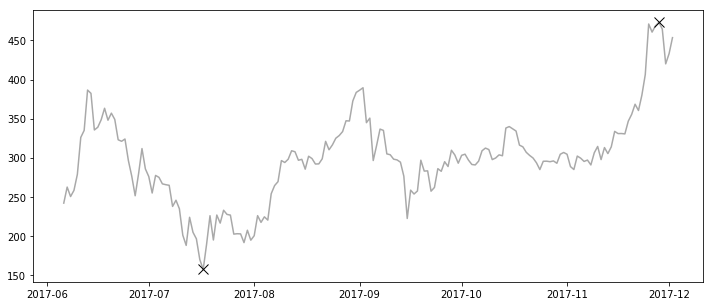

In [6]:
vbt.graphics.plot_line(rate_sr)

# indicators

Calculate EMA indicators.

In [35]:
fast_ma_sr = vbt.indicators.EMA(rate_sr, span=5)
slow_ma_sr = vbt.indicators.EMA(rate_sr, span=21)

# signals

Generate signals based on conditions.

    1. Go long whenever fast EMA is over slow EMA, while go short when opposite occurs.

In [36]:
ma_entries = vbt.signals.DMAC_entries(fast_ma_sr, slow_ma_sr)
ma_exits = vbt.signals.DMAC_exits(fast_ma_sr, slow_ma_sr)

Both, entry and exit vectors, are sequences of 0 and 1 (bit-vectors) to allow fast vector operations.

We reduce both vectors to contain only signals that are first in their sequences, since we are looking for crossover.

In [37]:
ma_entries = vbt.bitvector.first(ma_entries)
ma_exits = vbt.bitvector.first(ma_exits)

    2. Go short whenever price drops by 10%.

In [38]:
# trailstop_exits = vbt.signals.trailstop_exits(rate_sr, ma_entries, 0.1 * rate_sr)

Combine MA exit strategy with trailing stop and pick every first exit out of sequence.

In [39]:
# ma_exits = vbt.bitvector.OR(ma_exits, trailstop_exits)
# ma_exits = vbt.bitvector.first(ma_exits)

To apply an additional filter, generate your own bit-vector and use `vector.AND/OR/XOR` operations.

# positions

Generete positions out of both vectors (merge and reduce).

In [40]:
pos_sr = vbt.positions.from_signals(rate_sr, ma_entries, ma_exits)
pos_sr.head()

date
2017-06-07    1
2017-06-24   -1
2017-08-04    1
2017-09-09   -1
2017-09-28    1
dtype: int64

Position series is a binary series, where 1 = going long and -1 = going short. There is no two long/short positions in a row, since we want a clean way to evaluate a strategy (only the logic of a strategy must have an impact on the equity, not the investment size or its distribution)

Visualize entries and exits.

   count       mean        std       min        25%       50%        75%  \
0    4.0  67.700912  61.406119 -9.957731  43.549708  70.89276  95.043965   

          max  
0  138.975861  


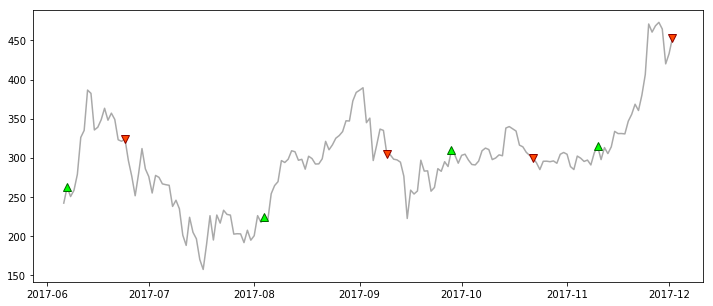

In [41]:
vbt.positions.plot(rate_sr, pos_sr)

# equity

Generate equity from positions, based on fees and slippage.

In [42]:
equity_sr = vbt.equity.from_positions(rate_sr, pos_sr, investment, fees, slippage)
equity_sr.head()

date
2017-06-06            NaN
2017-06-07     975.047380
2017-06-08     930.119603
2017-06-09     959.449964
2017-06-10    1035.383472
dtype: float64

Equity is NaN before the first entry or if no positions were taken.

Visualize base and quote equities.

base: equity - hold
   count        mean         std         min         25%         50%  \
0  179.0  238.900327  156.449914 -140.300118  169.359577  265.565846   

          75%         max  
0  340.339167  642.232936  


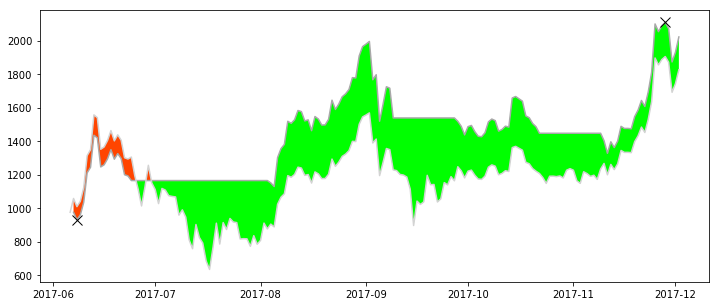

quote: equity - hold
   count      mean       std       min       25%       50%     75%       max
0  179.0  0.869052  0.645523 -0.433044  0.431677  0.875992  1.0953  3.372051


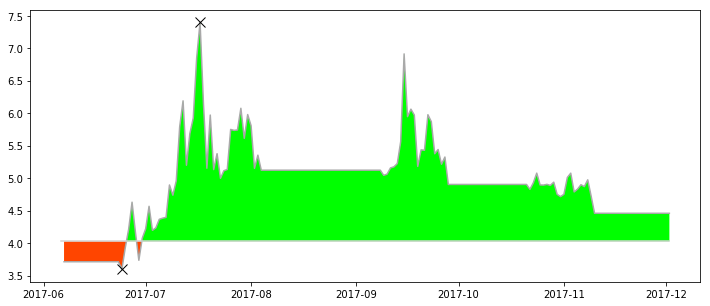

In [43]:
vbt.equity.plot(rate_sr, equity_sr)

# returns

Generate returns.

In [44]:
returns_sr = vbt.returns.from_equity(equity_sr)
returns_sr.head()

date
2017-06-06    0.000000
2017-06-07    0.000000
2017-06-08   -0.046078
2017-06-09    0.031534
2017-06-10    0.079143
dtype: float64

Draw returns.

   count     mean       std       min       25%  50%       75%       max
0   26.0  0.02463  0.102483 -0.136614 -0.011529  0.0  0.074471  0.328091


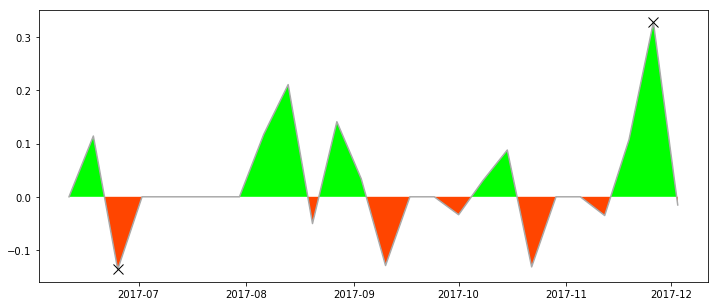

In [45]:
vbt.returns.plot(vbt.returns.resample(returns_sr, 'W'))

# performance

Print summary of multiple KPIs applied on returns.

In [46]:
vbt.performance.summary(returns_sr)

distribution         count         180.000000
                     mean            0.004860
                     std             0.040431
                     min            -0.154448
                     25%            -0.001580
                     50%             0.000000
                     75%             0.010372
                     max             0.169088
performance          profit          1.073858
                     avggain         0.043035
                     avgloss         0.031747
                     winrate         0.539216
                     expectancy      0.010528
                     maxdd           0.334688
risk/return profile  sharpe          0.120207
                     sortino         0.140326
dtype: float64

# optimizer.gridsearch

The classic optimization method is grid search (or exhaustive search). It exhaustively generates candidates from a grid of parameter values and applies them on the series. 

This method brings some advantages:
- its simple to implement
- 2d-combinations can be visualized using heatmaps
- can be used to discover hidden patterns in combinations
- highly parallelizable

But also drawbacks are possible:
- not flexible enough to fit changing financial markets
- prone to overfitting
- no intermediate feedback

**Grid search consists of 3-4 levels:**

| Level | Motivation | Module | Structure |
|-|-|-|-|
| 1 | Calculate position/equity/returns maps | `srmap` | `{param: pd.Series}` |
| 2 | Calculate KPIs | `nummap` | `pd.Series` |
| 3 (optional) | Combine multiple KPIs into a single score and compare | `scoremap` | `pd.Series` |
| 4 | Build heatmap to examine hidden patterns | `matrix` | `pd.DataFrame` |

At the end we will be able to compare performance of different trading strategies.

## L1
## srmap

In [19]:
import vectorbt.optimizer.gridsearch as grids

Calculate returns for a set of MA window combinations.

    1. Precalculate all MAs.

In [20]:
# Init
ma_func = lambda span: vbt.indicators.EMA(rate_sr, span=span)
min_ma, max_ma, step = 1, 100, 1
fees = 0.0025

# Cache moving averages
param_range = grids.params.range_params(min_ma, max_ma, step)
ma_cache = dict(grids.srmap.from_func(ma_func, param_range))

cores: 4
processes: 1
starmap: False
calcs: 100 (~0.07s) ..
done. 0.04s


    2. For each MA combination, generate position series.

In [21]:
# Params
ma_space = grids.params.combine_rep_params(min_ma, max_ma, step, 2)

# Func
def ma_positions_func(fast_ma, slow_ma):
    # Cache
    fast_ma_sr = ma_cache[fast_ma]
    slow_ma_sr = ma_cache[slow_ma]
    # Signals
    entries = vbt.signals.DMAC_entries(fast_ma_sr, slow_ma_sr)
    entries = vbt.bitvector.first(entries)
    exits = vbt.signals.DMAC_exits(fast_ma_sr, slow_ma_sr)
    exits = vbt.bitvector.first(exits)
    # Positions
    pos_sr = vbt.positions.from_signals(rate_sr, entries, exits)
    return pos_sr

In [22]:
ma_positions_srmap = grids.srmap.from_func(ma_positions_func, ma_space)

cores: 4
processes: 1
starmap: True
calcs: 5050 (~5.10s) ..
done. 1.92s


    3. For each position series, generate returns series.

We need to separate position and returns calculation, since we need number of positions of each MA combination for a random map.

In [23]:
def ma_returns_func(fast_ma, slow_ma):
    # Equity
    pos_sr = ma_positions_srmap[(fast_ma, slow_ma)]
    equity_sr = vbt.equity.from_positions(rate_sr, pos_sr, investment, fees, slippage)
    # Returns
    returns_sr = vbt.returns.from_equity(equity_sr)
    return returns_sr

In [24]:
ma_returns_srmap = grids.srmap.from_func(ma_returns_func, ma_space)

cores: 4
processes: 1
starmap: True
calcs: 5050 (~8.90s) ..
done. 5.23s


For each MA window combination generate random positions of same length and resulting returns. 

In [25]:
# Params
random_space = [(fma, sma, len(np.flatnonzero(ma_positions_srmap[(fma, sma)].values))) for fma, sma in ma_space]

# Func
def random_returns_func(slow_ma, fast_ma, n):
    # Positions
    pos_sr = vbt.positions.random(rate_sr, n)
    # Equity
    equity_sr = vbt.equity.from_positions(rate_sr, pos_sr, investment, fees, slippage)
    # Returns
    returns_sr = vbt.returns.from_equity(equity_sr)
    return returns_sr

In [26]:
random_returns_srmap = grids.srmap.from_func(random_returns_func, random_space)

cores: 4
processes: 1
starmap: True
calcs: 5050 (~23.16s) ..
done. 6.68s


## L2
## nummap

Apply KPI on each returns series.

In [27]:
if_i_hold = vbt.performance.profit(rate_sr.pct_change())
profit = lambda r: vbt.performance.profit(r) - if_i_hold
ma_profit_nummap = grids.nummap.from_srmap(ma_returns_srmap, vbt.performance.profit)

cores: 4
processes: 1
starmap: False
calcs: 5050 (~6.51s) ..
done. 3.98s
min (1, 5): -0.76862132663
max (5, 21): 1.07385782616


In [28]:
sharpe = lambda r: vbt.performance.sharpe(r, nperiods=252)
ma_sharpe_nummap = grids.nummap.from_srmap(ma_returns_srmap, sharpe)

cores: 4
processes: 1
starmap: False
calcs: 5050 (~1.90s) ..
done. 0.57s
min (1, 5): -2.0916136364
max (6, 19): 1.90822399689


In [29]:
random_profit_nummap = grids.nummap.from_srmap(random_returns_srmap, vbt.performance.profit)

cores: 4
processes: 1
starmap: False
calcs: 5050 (~4.77s) ..
done. 3.09s
min (1, 2, 67): -0.903138568246
max (35, 99, 3): 2.61200514552


Compare quantile distributions of EMA and random strategy.

            count      mean       std       min       25%       50%       75%  \
nummap     5050.0  0.280062  0.268921 -0.768621  0.031299  0.330508  0.484668   
benchmark  5050.0  0.314920  0.481939 -0.903139 -0.025826  0.265183  0.591943   

                max  
nummap     1.073858  
benchmark  2.612005  


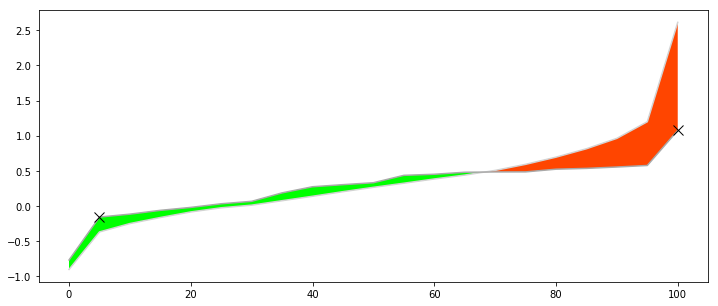

In [30]:
grids.nummap.compare_quantiles(ma_profit_nummap, random_profit_nummap)

Compare their KPI distributions.

            count      mean       std       min       25%       50%       75%  \
nummap     5050.0  0.280062  0.268921 -0.768621  0.031299  0.330508  0.484668   
benchmark  5050.0  0.314920  0.481939 -0.903139 -0.025826  0.265183  0.591943   

                max  
nummap     1.073858  
benchmark  2.612005  


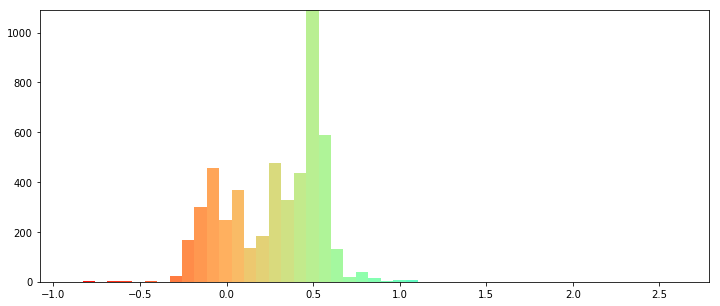

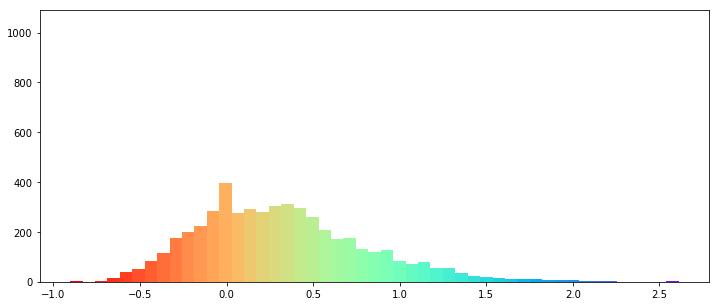

In [31]:
cmap = plt.cm.rainbow_r
norm = plt.Normalize()
grids.nummap.compare_hists(ma_profit_nummap, random_profit_nummap, 50, cmap, norm)

## L3
## scoremap

Take into account multiple weighted KPIs and generate a score from 1 to 100.

In [32]:
ma_scoremap = grids.scoremap.from_nummaps([ma_profit_nummap, ma_sharpe_nummap], [2/3, 1/3], [False, False])

done. 0.01s
min (1, 5): 1.0
max (6, 18): 100.0


## L4
## matrix

Reshape 2d-parameter grid into a matrix.

In [33]:
ma_matrix = grids.matrix.from_nummap(ma_profit_nummap, symmetric=True).fillna(0)

done. 1.81s


Display as a heatmap.

     count      mean       std       min       25%       50%       75%  \
0  10000.0  0.282862  0.268779 -0.768621  0.038997  0.330508  0.484668   

        max  
0  1.073858  


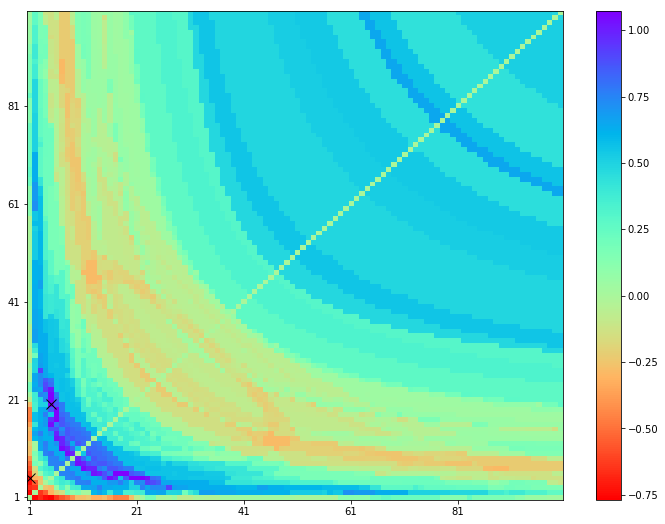

In [34]:
cmap = plt.cm.rainbow_r
norm = plt.Normalize()
matplotlib.rcParams['figure.figsize'] = (12, 9)
grids.matrix.plot(ma_matrix, cmap, norm)
matplotlib.rcParams['figure.figsize'] = (12, 5)